In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

### Загрузим датасет с машинами. Цель - верно восстанавливать для каждой из них цену продажи!

In [2]:
data = pd.read_csv('autos.csv')

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [3]:
### Колонка с тергетом - "selling price"

X = data.drop("selling_price", axis=1)
y = data["selling_price"]

### Будем замерять MSLE!
### Поэтому прологарифмируем таргет
### А после оптимизируем MSE

y = y.apply(np.log1p)

In [4]:
### Разделим выборку на трейн и тест!
### Your code is here
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

__Задание__ 

Реализуйте свой MeanTargetEncoder с добавленем некоторого шума!

Однажды в лекционном материале, обсуждая счетчики, мы говорили с вами о том, что из-за них модели могут переобучаться. Один из способов бороться с этим - валидировать расчеты среднего таргета (стратегия отложенной выборки / расчеты на кросс-валидации). Но есть еще проще!

Можно просто к значению счетчика добавить случайный шум (зашумить данные)!

Напомним, что рассчитываться новые признаки должны по такой формуле:

$$
g_j = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}{l} + C * \epsilon
$$



Пусть шум будет случайной величиной из нормального стандартного распределения, то есть $\epsilon \sim N(0, 1) $, а $ C = 0.006$.

Создавая свой класс-трансформер, наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`. Трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и список из числовых признаков. 

Если для какого-то признака в тестовой выборке отсутствует значение, трансформер должен поставить там 0.

На выходе должен получиться датасет того же размера с измененными категориальными признаками.

Класс MeanTargetEncoderNoise должен иметь следующую сигнатуру:



Разделите колонки на вещественные и категориальные. Приведите все категориальные колонки к типу `object`.

Далее применим наш кодировщик к `X_train, X_test`, так же как например мы применяем `StandardScaler`, чтобы проверить работоспособность нашего класса. Установите зерно датчика случайный чисел `np.random.seed(1)`.

После того, как вы изменили обучающую и тестовую выборки, сохраните первые 10 строк полученного промежуточного датафрейма обучающей выборки (`X_train`) в файл в формате csv с сепаратором `;`. Не забудьте индекс. Отправьте полученный файл в форму ниже.

Список колонок которые должны быть в файле для сдачи:
```py
cols = [
    "km_driven",
    "name",
    "year",
    "fuel",
    "seller_type",
    "transmission",
    "owner"
]
```

### Ваше решение


Разделение колонок на категориальные и числовые.

In [5]:
object_cols = ['name', 'year', 'fuel', 'seller_type', 'transmission', 'owner']
num_cols = ['km_driven']

X.head()

,name,year,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,141000,Diesel,Individual,Manual,Second Owner


Реализация класса MeanTargetEncoderNoise.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoderNoise(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical, numeric):
        
        ### Your code is here
        
        self.categorical = categorical
        self.numeric = numeric
    
    def fit(self, X, y):
        ### Your code is here
        
        def noisy_mean(x):
            return np.mean(x) + 0.006 * np.random.normal()
        
        self.categorical_counters = X[self.categorical].apply(
        lambda col: y.groupby(col).apply(noisy_mean).to_dict()
        ).to_dict()
        
        return self
        
    def transform(self, df):
        ### Your code is here
        temp = df.copy()
        
        for feature, replace_dict in self.categorical_counters.items():
            temp.loc[
                ~temp[feature].isin(replace_dict.keys()), feature
            ] = 0
            temp[feature] = temp[feature].replace(replace_dict)
        return temp

Проверка работы трансформера.

In [7]:
np.random.seed(1)
transformer = MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)

transformer.fit(X_train, y_train)

train = transformer.transform(X_train)
test = transformer.transform(X_test)

train.head(10)

,name,year,km_driven,fuel,seller_type,transmission,owner
3294,13.483692,13.436559,50000,13.093756,12.615863,13.771135,12.977730
2290,12.117029,11.903115,70000,12.453832,12.615863,13.771135,12.977730
874,12.310456,13.328864,50000,12.453832,12.615863,12.639805,12.977730
1907,12.491443,13.042359,92198,12.453832,13.152824,12.639805,12.463313
3244,12.390906,12.870886,3240,12.453832,12.615863,12.639805,12.463313
1089,12.687432,13.436559,10000,12.453832,13.152824,12.639805,12.977730
3902,11.698702,11.503504,90000,12.453832,12.615863,12.639805,11.878390
2215,11.120678,11.503504,79000,12.453832,12.615863,12.639805,12.463313
3862,13.172879,13.328864,99700,13.093756,12.615863,12.639805,12.977730
705,13.004194,12.241213,124000,13.093756,12.615863,12.639805,12.463313


In [8]:
train.head(10).to_csv('5.csv', sep=';', index=False)

Обучите несколько деревьев, перебирая максимальную глубину алгоритма из списка `max_depth_list`, а остальные параметры оставьте дефолтными. Выведите лучшее значение гиперпараметра. Постройте график зависимости MSLE на тестовой выборке от значения гиперпараметра. Воспользуйтесь `Pipeline` без `GridSearch`. Проделайте то же самое с `min_samples_split`, `min_impurity_decrease`, `max_leaf_nodes`. (по 2б на каждый параметр)

In [9]:
max_depth_list = [3, 5, 8, 12]
min_samples_split_list = [10, 50, 100, 500]
min_impurity_decrease_list = [0, 0.1, 0.15, 0.2]
max_leaf_nodes_list = [100, 200, 500]

In [10]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

np.random.seed(1)

### Your code is here

### Найдем лучшую глубину 
rmse_depth = {}

for max_depth in max_depth_list:
    pipe = Pipeline([('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
    ('tree', DecisionTreeRegressor(max_depth=max_depth))])
    
    pipe.fit(X_train, y_train)
    
    preds = pipe.predict(X_test)
    
    rmse_depth[max_depth] = round(mse(preds, y_test, squared=True), 3)
    
    
### Найдем лучшее минимальное количество объектов в вершине
rmse_split = {}
for split in min_samples_split_list:
    pipe = Pipeline([('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
    ('tree', DecisionTreeRegressor(min_samples_split=split))])
    
    pipe.fit(X_train, y_train)
    
    preds = pipe.predict(X_test)
    
    rmse_split[split] = round(mse(preds, y_test, squared=True), 3)

### Найдем лучшее максимальное количество листьев
rmse_leaf = {}
for leaf in max_leaf_nodes_list:
    pipe = Pipeline([('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
    ('tree', DecisionTreeRegressor(max_leaf_nodes=leaf))])
    
    pipe.fit(X_train, y_train)
    
    preds = pipe.predict(X_test)
    
    rmse_leaf[leaf] = round(mse(preds, y_test, squared=True), 3)


### Найдем лучшее минимальное улучшения критерия качества 
rmse_decrease = {}

for decrease in min_impurity_decrease_list:
    pipe = Pipeline([('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
    ('tree', DecisionTreeRegressor(min_impurity_decrease=decrease))])
    
    pipe.fit(X_train, y_train)
    
    preds = pipe.predict(X_test)
    
    rmse_decrease[decrease] = round(mse(preds, y_test, squared=True), 3)
    
print(f'''depth: {rmse_depth}
split: {rmse_split}
leaf: {rmse_leaf}
decrease: {rmse_decrease}
''')

depth: {3: 0.798, 5: 1.441, 8: 1.988, 12: 1.983}
split: {10: 1.433, 50: 1.438, 100: 0.952, 500: 0.808}
leaf: {100: 1.989, 200: 1.983, 500: 1.985}
decrease: {0: 1.985, 0.1: 0.521, 0.15: 0.52, 0.2: 0.52}



Изобразим результаты качества в зависимости от изменения отдельных параметров

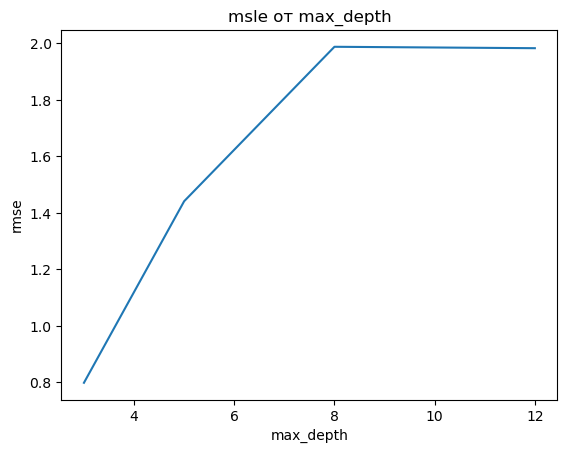

In [11]:
plt.plot(max_depth_list, rmse_depth.values())
plt.title('msle от max_depth')
plt.xlabel('max_depth')
plt.ylabel('rmse');

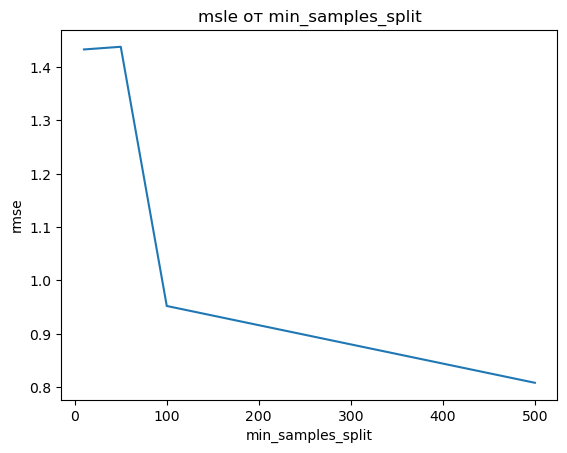

In [12]:
plt.plot(min_samples_split_list, rmse_split.values())
plt.title('msle от min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('rmse');

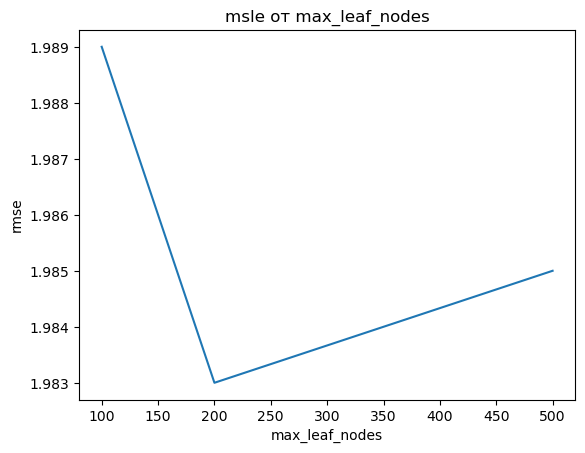

In [13]:
plt.plot(max_leaf_nodes_list, rmse_leaf.values())
plt.title('msle от max_leaf_nodes')
plt.xlabel('max_leaf_nodes')
plt.ylabel('rmse');

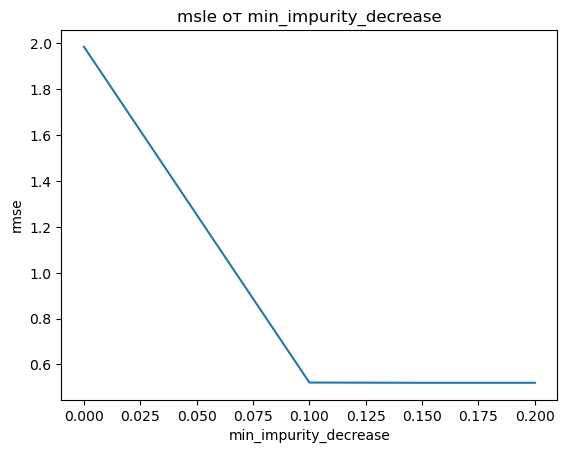

In [14]:
plt.plot(min_impurity_decrease_list, rmse_decrease.values())
plt.title('msle от min_impurity_decrease')
plt.xlabel('min_impurity_decrease')
plt.ylabel('rmse');

Подберите лучшую комбинацию параметров, используя `GridSearchCV` и набор массивов значений параметров из предыдущего задания. Для лучшей комбинации посчитайте MSLE на тестовой выборке. Получились ли лучшие параметры такими же, как если бы вы подбирали их по-отдельности при остальных гиперпараметрах по умолчанию (предыдущее задание)? (2б)

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "decision_tree__max_depth": [3, 5, 8, 12],
    "decision_tree__min_samples_split": [10, 50, 100, 500],
    "decision_tree__min_impurity_decrease": [0, 0.1, 0.15, 0.2],
    "decision_tree__max_leaf_nodes": [100, 200, 500]
}
np.random.seed(1)

### Your code is here

pipe = Pipeline([('transformer', MeanTargetEncoderNoise(categorical=object_cols, numeric=num_cols)),
    ('decision_tree', DecisionTreeRegressor())])

grid = GridSearchCV(pipe, 
                   param_grid,
                   cv=4,
                   scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('transformer',
                                        MeanTargetEncoderNoise(categorical=['name',
                                                                            'year',
                                                                            'fuel',
                                                                            'seller_type',
                                                                            'transmission',
                                                                            'owner'],
                                                               numeric=['km_driven'])),
                                       ('decision_tree',
                                        DecisionTreeRegressor())]),
             param_grid={'decision_tree__max_depth': [3, 5, 8, 12],
                         'decision_tree__max_leaf_nodes': [100, 200, 500],
                         'decision_tree__min_impurity_decrease': [0, 0.1, 0.15,
                                                                  0.2],
                         'decision_tree__min_samples_split': [10, 50, 100,
                                                              500]},
             scoring='neg_mean_squared_error')

In [16]:
### Замерим MSE на лучшей модели

mse(grid.best_estimator_.predict(X_test), y_test, squared=True)

0.5197845418970932